# A Simple Trick for Dealing with Overlapping Data

[Last week](https://robotwealth.com/how-to-test-the-assumption-of-persistence/), we looked at simple data analysis techniques to test for persistence. 

But we only looked at a feature that is measured over a single day - the absolute range. 

Such a feature makes it easy to test persistence because you don't have the problem of overlapping data. Each data point is entirely self-contained and shares no information with the previous data point. 

Compare this with a feature that's calculated over a number of days, for example volatility estimated as the standard deviation of the previous 30 days' returns. 

*Today's estimate only differs from tomorrow's estimate by a single data point.*

In the plot below, we have recent price action for SPY. We estimate volatility using the previous 30 days' returns. The orange section covers the data points used to estimate today's volatility. The dark blue section covers the data used to estimate yesterday's volatility. The light blue shading shows the extent of the overlapping data - today's estimate shares 29 data points with yesterday's estimate! That means that the two estimates are going to be very similar by design. 

![](https://rw-site-media.storage.googleapis.com/wp-content/uploads/2024/04/23125631/overlapping_data.png)

Say we want to test the assumption of persistence of 30-day volatility.

Since each day's volatility estimate shares so much data with the previous one, we introduce persistence by design - if my estimates share a lot of data, then they're going to look sticky because they're essentially the same thing. 

Here's a scatterplot of today's 30-day vol versus yesterday's 30-day vol for the GLD ETF:

In [5]:
# setup
library(tidyverse)
library(roll)

# set chart options
options(repr.plot.width = 14, repr.plot.height = 7, warn = -1)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# load some data - daily prices for macro etfs:
prices <- read_csv("https://raw.githubusercontent.com/Robot-Wealth/trader-tales/master/data/macro_etfs.csv")
prices %>% head

Rows: 34946 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (6): open, high, low, close, volume, closeadjusted
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,volume,closeadjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DBC,2010-01-04,25.17,25.240,25.072,25.24,2046900,23.239
EMB,2010-01-04,101.74,101.930,101.330,101.93,120500,52.392
GLD,2010-01-04,109.82,110.140,109.310,109.80,16224100,109.800
IEF,2010-01-04,88.74,88.950,88.630,88.82,619100,66.539
TLT,2010-01-04,89.84,90.100,89.580,89.81,2829100,60.998
TMF,2010-01-04,77.65,78.475,77.275,78.10,9640,66.373


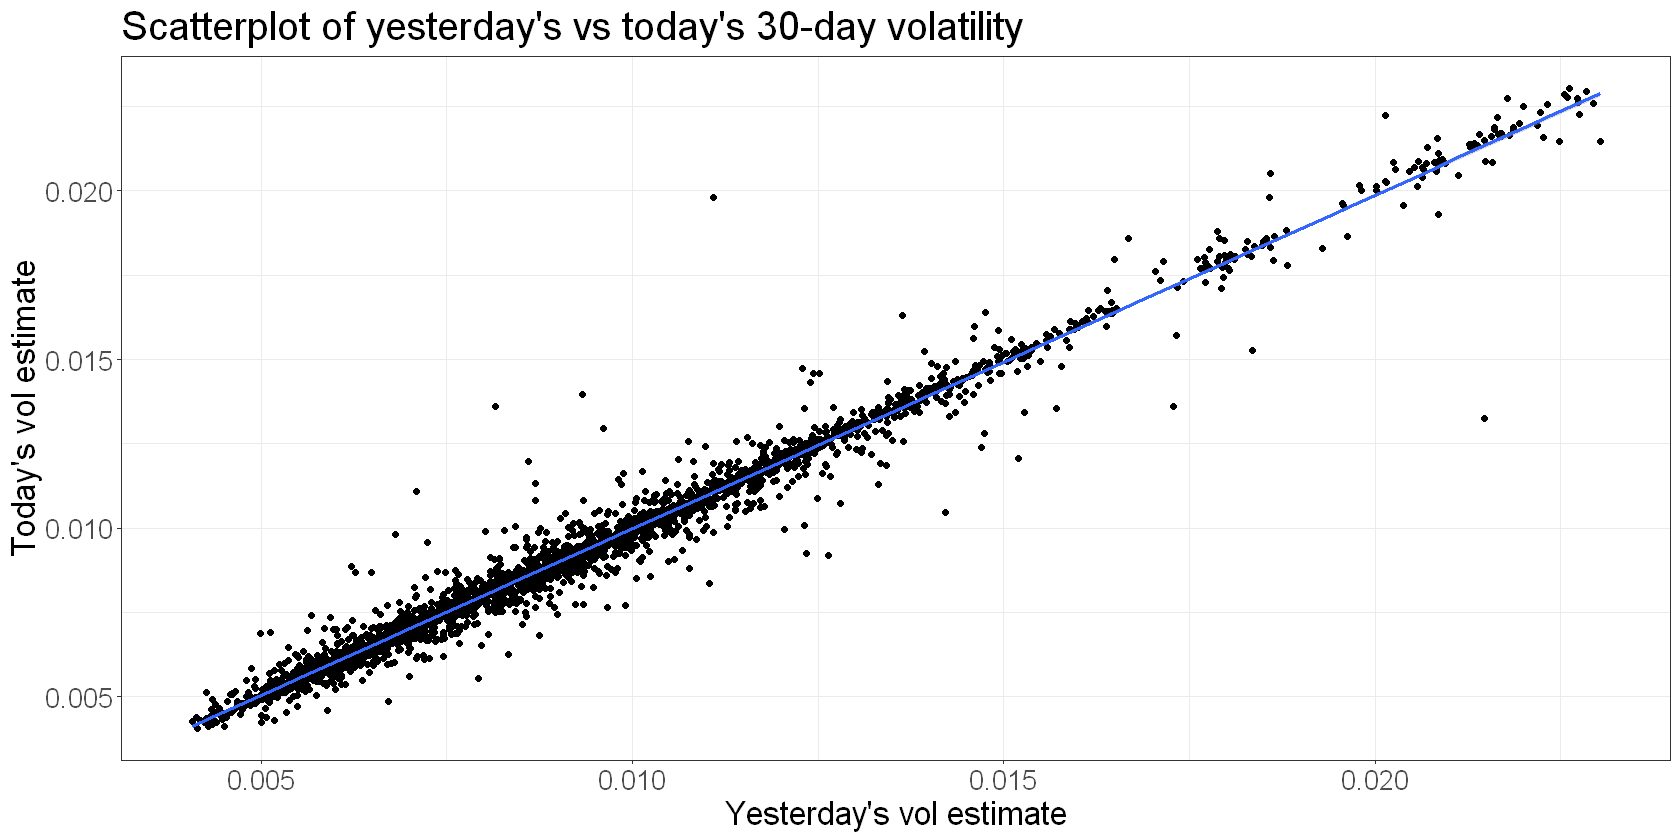

In [12]:
prices %>% 
  # get prices for GLD
  filter(ticker == "GLD") %>% 
  # calculate returns
  arrange(date) %>% 
  mutate(log_return = log(close/dplyr::lag(close))) %>% 
  na.omit() %>% 
  # calculate rolling 30-day vol
  mutate(vol_30 = roll_sd(log_return, width = 30)) %>% 
  # calculate lagged vol 
  mutate(vol_30_lag = dplyr::lag(vol_30)) %>% 
  na.omit() %>% 
  # plot
  ggplot(aes(x = vol_30_lag, y = vol_30)) +
  geom_point() +
  geom_smooth(method = "lm", formula = "y ~ x") +
  labs(
    x = "Yesterday's vol estimate",
    y = "Today's vol estimate",
    title = "Scatterplot of yesterday's vs today's 30-day volatility"
  )


It looks like an extremely strong relationship - but that's mostly due to the shared data.  

A common sign that you've got overlapping data biasing your results, in addition to an unusually strong relationship, is the pattern you see where points on the scatter plot appear to be chasing each other in little circles or arcs, like you see in the top right and the middle of the scatter plot above. 

## Dealing with overlapping data

To remove the bias due to overlapping data, we need to remove observations that share data. In our case, since our volatility is estimated using a 30-period window, we would simply take every 30th observation (observation 30 shares no data with observation 60, which shares no data with observation 90, and so on).

We can do that in R by using `dplyr::filter` with an expression using the `row_number` function and the [modulo](https://en.wikipedia.org/wiki/Modulo) or remainder operator (`%%`). We must do this filtering operation *before* lagging our vol estimate:

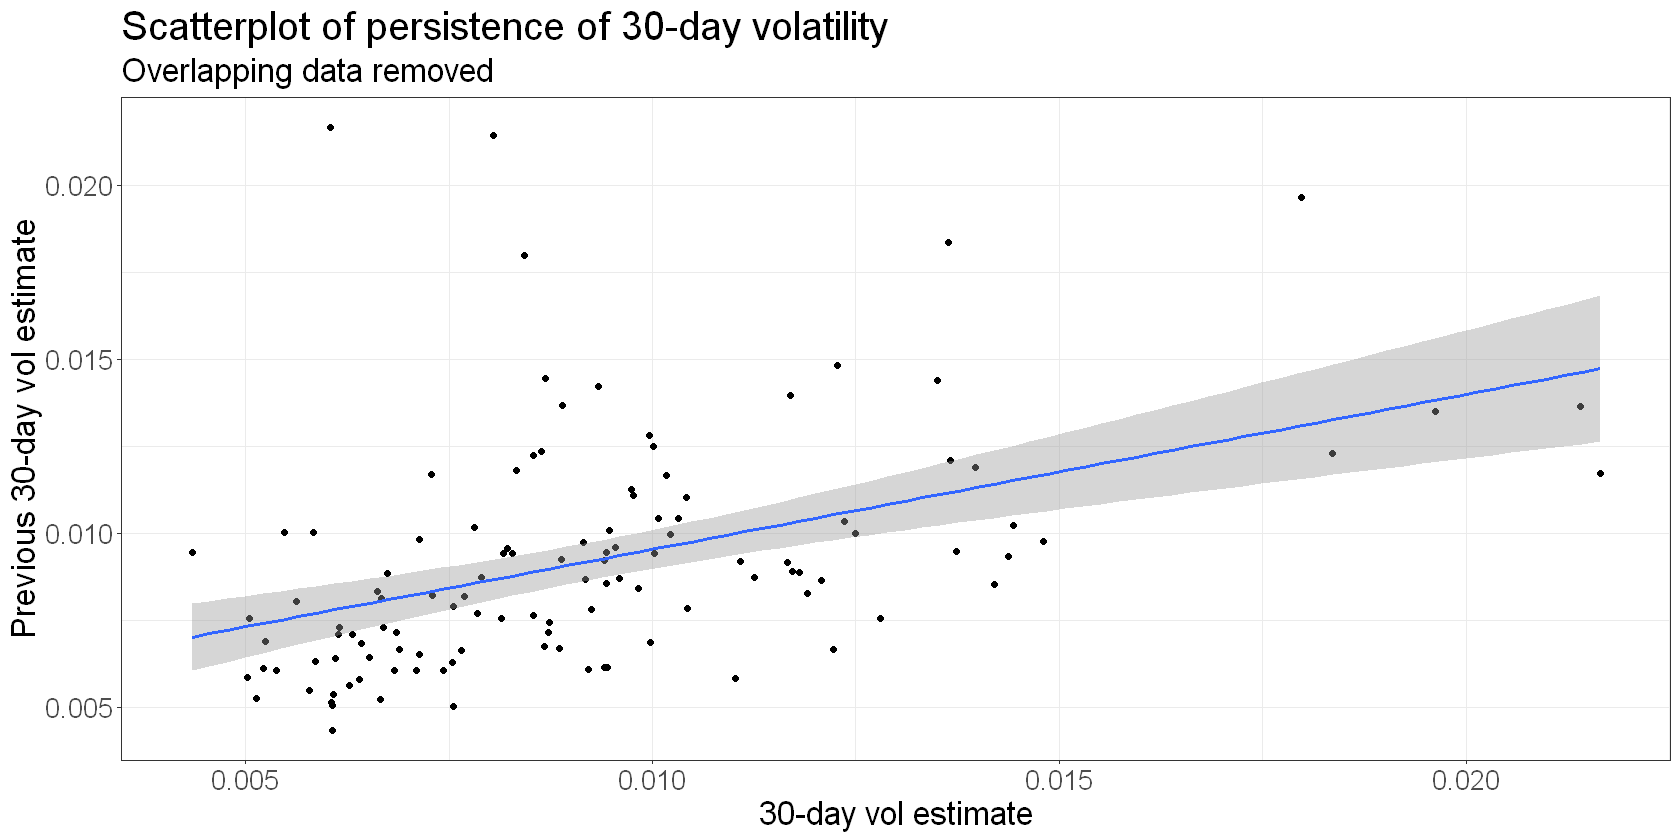

In [16]:
prices %>% 
  # get prices for GLD
  filter(ticker == "GLD") %>% 
  # calculate returns
  arrange(date) %>% 
  mutate(log_return = log(close/dplyr::lag(close))) %>% 
  na.omit() %>% 
  # calculate rolling 30-day vol
  mutate(vol_30 = roll_sd(log_return, width = 30)) %>% 
  # deal with overlapping data by keeping only every 30th observation
  dplyr::filter(row_number() %% 30 == 0) %>%
  # calculate lagged vol 
  mutate(vol_30_lag = dplyr::lag(vol_30)) %>% 
  na.omit() %>% 
  # plot
  ggplot(aes(x = vol_30_lag, y = vol_30)) +
  geom_point() +
  geom_smooth(method = "lm", formula = "y ~ x") +
  labs(
    x = "30-day vol estimate",
    y = "Previous 30-day vol estimate",
    title = "Scatterplot of persistence of 30-day volatility",
    subtitle = "Overlapping data removed"
  )


We've now removed the inherent bias due to overlapping data and we get a clearer view of the actual, unbiased persistence of 30-day volatility.  

Notice the trade-off however - we now have much fewer data points. 

One way to partially deal with this is to start from a different point in our series before filtering every 30th observation. So instead of getting observation 30, 60, 90, 120, etc, we get say observation 15, 45, 75, 105, etc. 

That is, we get a different set of non-overlapping observations. 

In R, we can do this with with another call to `dplyr::filter` using the `row_number` function:

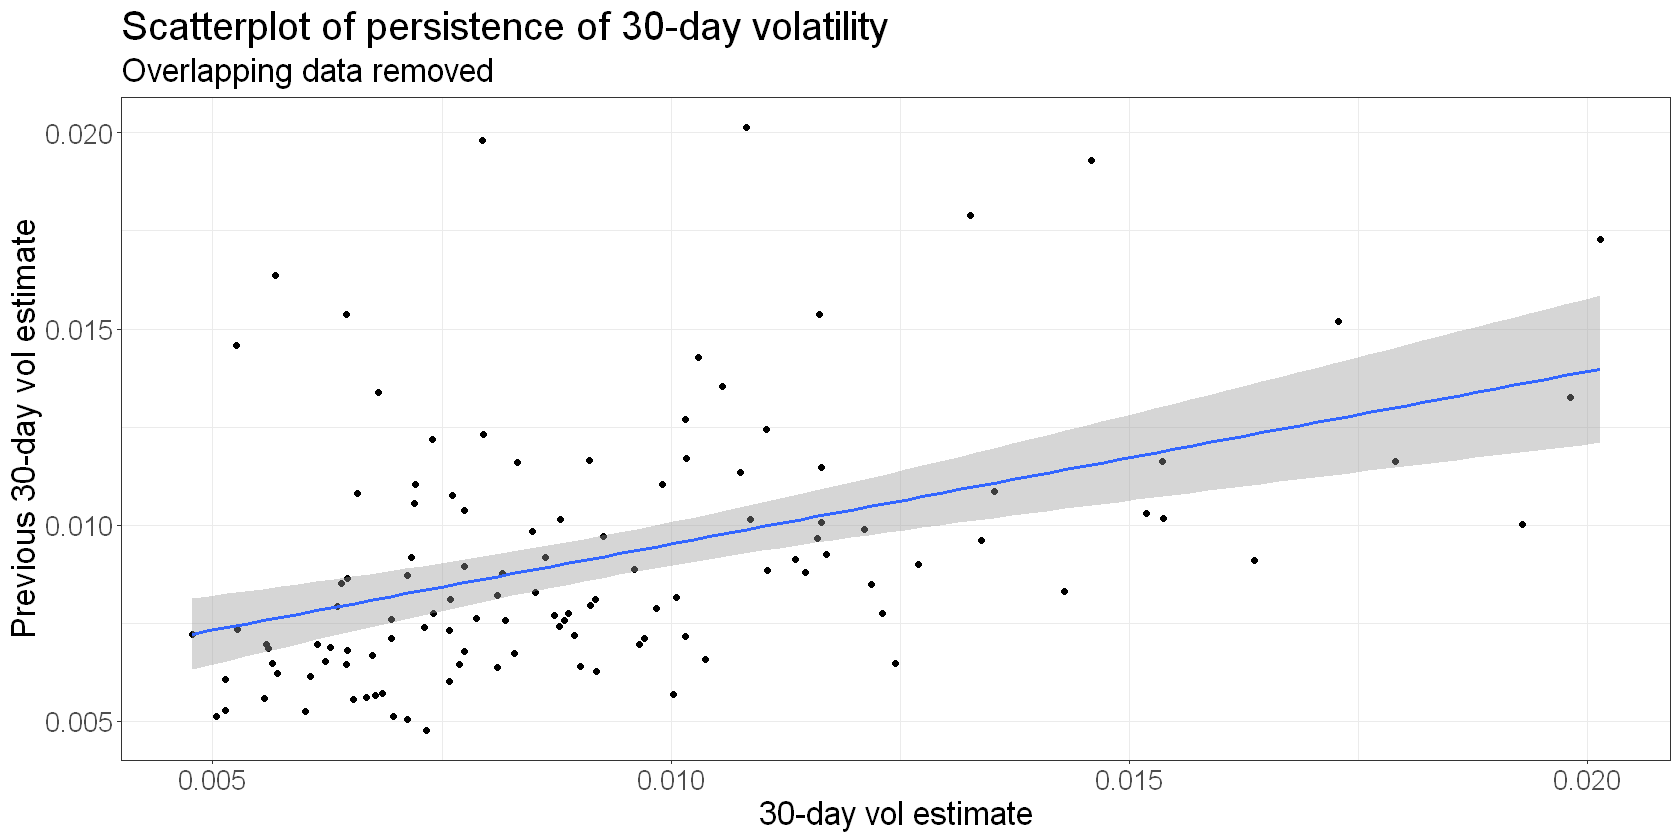

In [18]:
prices %>% 
  # get prices for GLD
  filter(ticker == "GLD") %>% 
  # calculate returns
  arrange(date) %>% 
  mutate(log_return = log(close/dplyr::lag(close))) %>% 
  na.omit() %>% 
  # calculate rolling 30-day vol
  mutate(vol_30 = roll_sd(log_return, width = 30)) %>% 
  # start from a different point in our series to get a different set of non-overlapping observations
  dplyr::filter(row_number() >= 15) %>% 
  # deal with overlapping data by keeping only every 30th observation
  dplyr::filter(row_number() %% 30 == 0) %>%
  # calculate lagged vol 
  mutate(vol_30_lag = dplyr::lag(vol_30)) %>% 
  na.omit() %>% 
  # plot
  ggplot(aes(x = vol_30_lag, y = vol_30)) +
  geom_point() +
  geom_smooth(method = "lm", formula = "y ~ x") +
  labs(
    x = "30-day vol estimate",
    y = "Previous 30-day vol estimate",
    title = "Scatterplot of persistence of 30-day volatility",
    subtitle = "Overlapping data removed"
  )


We get a slightly different plot, but the relationship is very similar. 

We could repeat this for as many unique sets of non-overlapping observations as we needed to be satisfied we had a good understanding of the relationship. 

## Conclusion

Whenever we estimate features using rolling windows of data, it's important to consider any biases introduced due to data sharing between unique observations.  This data sharing will make things look much more persistent than they really are. 

A simple way to deal with this is to filter observations that share data using `dplyr::filter(row_number() %% window_length == 0)`.

This results in a smaller set of unique observations, but we can get around that by simply starting from a different point in the series and evaluating different sets of unique non-overlapping observations. 